**Nome:** Iran Freitas Ribeiro

**Matrícula:** 2021241588

**Disciplina:** TEI - Estatística Aplicada

**Professor:** Celso José Munaro

In [23]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import OLS, ccf
plt.style.use("seaborn")

In [24]:
# x, y
Z = pd.read_csv("Data_epc10.csv", sep=";", header=None)
Z = Z.values
Ztreino_R = Z[:300]
ZCC_treino = Z[300:600]
ZCC_normal = Z[600:1200]
ZCC_falha = Z[1200:]

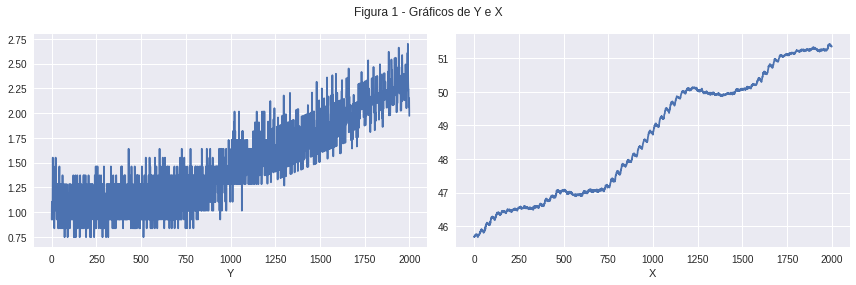

In [8]:
fig, ax = plt.subplots(figsize=(12,4), ncols=2)
ax[0].plot(Z[:, 1])
ax[0].set_xlabel("Y")
ax[1].plot(Z[:, 0])
ax[1].set_xlabel("X")
plt.suptitle("Figura 1 - Gráficos de Y e X")
plt.tight_layout()

# Questão 1

In [3]:
X1 = Ztreino_R[:, 0]
Y1 = Ztreino_R[:, 1]

In [25]:
# treinamento do modelo
Xr = sm.add_constant(X1) # adiciona coluna com 1s
m1 = OLS(Y1, Xr)
res1 = m1.fit() # ajusta modelo nos dados
b0, b1 = res1.params # betas

In [5]:
# verificando o modelo com novos dados (ZCC_treino)
Xtreino = ZCC_treino[:, 0]
Ytreino = ZCC_treino[:, 1]
y_hat = [(b0 + b1*xi) for xi in Xtreino]

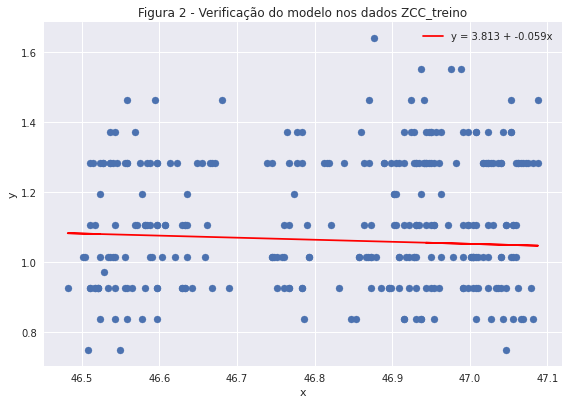

In [6]:
plt.scatter(Xtreino, Ytreino)
plt.plot(Xtreino, y_hat, c='red', label='y = {:.3f} + {:.3f}x'.format(b0, b1))
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.title("Figura 2 - Verificação do modelo nos dados ZCC_treino");

In [7]:
residuos_zc = [yi - yi_hat for yi, yi_hat in zip(Ytreino,y_hat)]
crus_corr = ccf(residuos_zc, residuos_zc, adjusted=False)

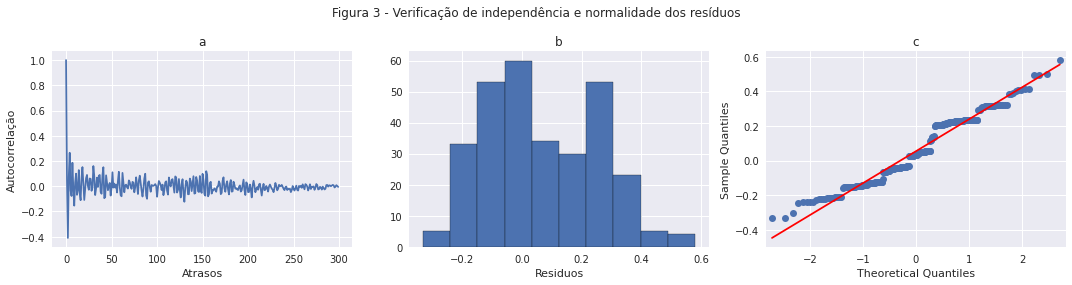

In [26]:
fig, ax = plt.subplots(figsize=(15,4), ncols=3)
ax[0].plot(crus_corr)
ax[1].hist(residuos_zc, edgecolor='black')
sm.qqplot(np.array(residuos_zc), line='s', ax=ax[2])
plt.suptitle("Figura 3 - Verificação de independência e normalidade dos resíduos")
ax[0].set_xlabel("Atrasos")
ax[0].set_ylabel("Autocorrelação")
ax[0].set_title("a")
ax[1].set_xlabel("Residuos")
ax[1].set_title("b")
ax[2].set_title("c")
plt.tight_layout();

# Questão 2

In [9]:
X2c = ZCC_treino[:, 0]
Y2c = ZCC_treino[:, 1]
b0, b1 = res1.params
# previsao de y usando X de ZCC_treino
Y_hat = [b0 + b1*xi for xi in X2c]


In [27]:
def controle(media, desvio, n, s=3):
    desvio_a = desvio/np.sqrt(n)
    ucl = media + s*desvio_a
    lcl = media - s*desvio_a
    return ucl, lcl

In [28]:
media_residuos, std_residuos = np.mean(residuos_zc), np.std(residuos_zc)

- Utilizar $n$ amostras ZCC_treino para obter os resíduos e calcular os limites do controle (ucl e lcl)
- Verificar FDR e FAR usando as bases ZCC_normal (true negative) e ZCC_falha (true positive)

In [29]:
X_normal = ZCC_normal[:, 0]
Y_normal = ZCC_normal[:, 1]

In [30]:
def get_amostras(X, Y, n):
    amostras_X = []
    amostras_Y = []
    i = 0
    while(i<len(X)):
        amostras_X.append(X[i:i+n])
        amostras_Y.append(Y[i:i+n])
        i = i+n
    return amostras_X, amostras_Y

In [31]:
def testes_graficos_controle(X, Y, ns=[], mediac=0, stdc=1, params=[]):
    # fig, ax = plt.subplots(nrows=len(ns))
    b0, b1 = params
    # amostras_nointervalo = []
    ultrapassam = []
    nao_ultrapassam = []
    for i, n in enumerate(ns):
        amostras_X, amostras_Y = get_amostras(X, Y, n)
        ucl2, lcl2 = controle(mediac, stdc, n, s=6)
        medias_residuos = []
        for a_x, a_y in zip(amostras_X, amostras_Y):
            if len(a_x)==n:
                y_hat_amostra = [b0 + b1*xi for xi in a_x]
                res_amostra = np.array(a_y) - np.array(y_hat_amostra)
                medias_residuos.append(res_amostra.mean())
        medias_residuos = np.array(medias_residuos)
        dentro_intervalo = [1 for m in medias_residuos if (ucl2>m) and (m>lcl2)]    
        soma_dentro = sum(dentro_intervalo)
        nao_ultrapassam.append(soma_dentro)
        ultrapassam.append(len(medias_residuos) - soma_dentro)
    return ultrapassam, nao_ultrapassam

In [32]:
lista_n = np.arange(1,60)
ultrapassam_normal, n_ultrapassam_normal = testes_graficos_controle(X_normal, Y_normal, lista_n, mediac=media_residuos, stdc=std_residuos, params=[b0, b1])

In [33]:
X_falha = ZCC_falha[:, 0]
Y_falha = ZCC_falha[:, 1]

In [34]:
ultrapassam_falha, n_ultrapassam_falha = testes_graficos_controle(X_falha, Y_falha, lista_n, mediac=media_residuos, stdc=std_residuos, params=[b0, b1])

- TP = True Positive: amostras de [1201, 2000] que ultrapassam o limiar\*100/800
- FP = False Positive: amostras de [601,1200] que ultrapassam o limiar\*100/600
- FN = False Negative: amostras de [1201, 2000] que não ultrapassam o limiar\*100/800
- TN = True negative: amostras de [601,1200] que não ultrapassam o limiar\*100/600

In [35]:
def FDR(TP, FP):
    return TP/(TP+FP)
def FAR(FN, TN):
    return FN/(FN+TN)

In [37]:
fdrs = [FDR(tp, fp) for tp,fp in zip(ultrapassam_falha, ultrapassam_normal)]
fars = [FAR(fn,tn) for fn, tn in zip(n_ultrapassam_falha, n_ultrapassam_normal)]

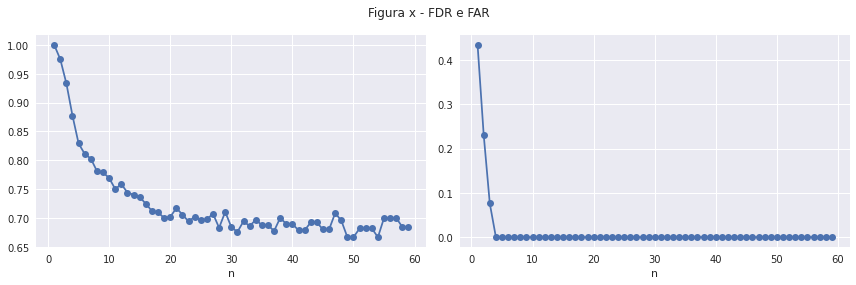

In [48]:
fig, ax = plt.subplots(figsize=(12,4), ncols=2)
ax[0].plot(lista_n, fdrs, marker='o')
ax[1].plot(lista_n, fars, marker='o')
ax[0].set_xlabel("n")
ax[1].set_xlabel("n")
plt.suptitle("Figura x - FDR e FAR")
plt.tight_layout();